<a href="https://colab.research.google.com/github/Pedro-Ortega-G/P_ESTOCASTICOS/blob/main/SCA_mlp_concatenate_3_ok_080325.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este cuaderno carga desde el ambiente de Colab una base de datos (energy_dataseet.csv) de generación de energia eléctrica de diferentes tipos; de entre los tipos de generación disponibles en la bases de datos se selecciona "generation_biomass" como serie de tiempo a procesar; se le aplica un preprocesamiento rellenando los valores faltantes (interpolación lineal); se divide espectralmente la serie usando la herramienta SCA (Spectral Component Analysis)en tres sub-series (tendencia, estacional y residual); se entrena un mlp (MinMaxScaler, 2 capas ocultas de 100 y 50 neuronas con activación relu) para cada sub-serie (80% de datos para entrenamiento y 20% para validación) usando ventanas temporales de 30 muestras; luego se concantenan (sumando) y se comparan con la señal original y se genera una visualización adicional de las últimas 200 muestras.


Valores nulos antes del procesamiento:
time                   0
generation biomass    19
dtype: int64

Valores nulos después del procesamiento:
time                  0
generation biomass    0
dtype: int64


<ipython-input-2-4996d4c61275>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_biomass["generation biomass"] = df_biomass["generation biomass"].interpolate(method="linear")


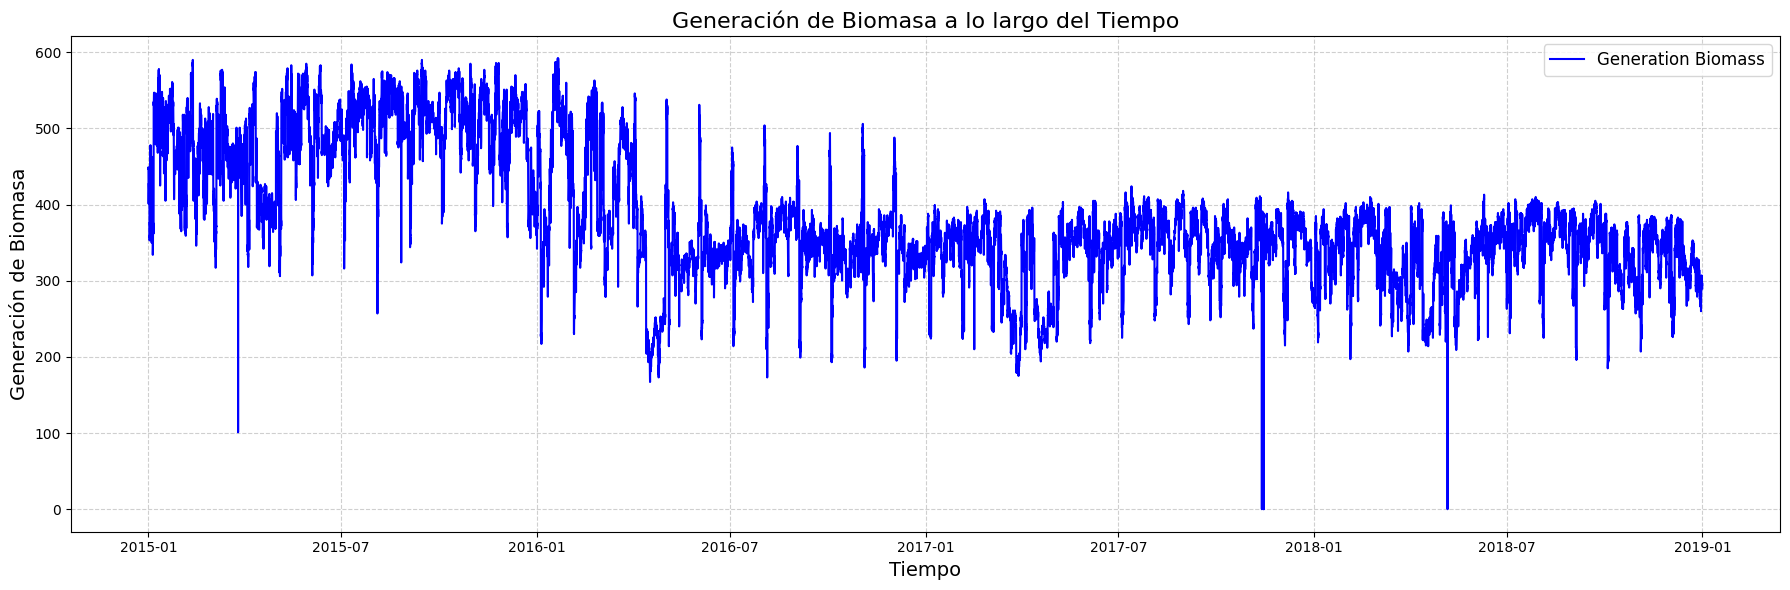

In [ ]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargar el archivo CSV
df = pd.read_csv("energy_dataset.csv")

# Convertir la columna 'time' a formato datetime
df['time'] = pd.to_datetime(df['time'], utc=True)

# Seleccionar la columna "generation biomass"
df_biomass = df[["time", "generation biomass"]]

# Mostrar información inicial sobre los valores nulos
print("Valores nulos antes del procesamiento:")
print(df_biomass.isnull().sum())

# Rellenar valores faltantes usando interpolación lineal
df_biomass["generation biomass"] = df_biomass["generation biomass"].interpolate(method="linear")

# Verificar que no quedan valores nulos
print("\nValores nulos después del procesamiento:")
print(df_biomass.isnull().sum())

# Función para visualizar la serie de tiempo
def plot_time_series(data, title="Serie de Tiempo"):
    """
    Visualiza una serie de tiempo.

    Args:
        data: DataFrame con columnas 'time' y 'generation biomass'.
        title: Título del gráfico.
    """
    plt.figure(figsize=(18, 6))
    plt.plot(data["time"], data["generation biomass"], color="blue", label="Generation Biomass")
    plt.title(title, fontsize=16)
    plt.xlabel("Tiempo", fontsize=14)
    plt.ylabel("Generación de Biomasa", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# Visualizar la serie de tiempo
plot_time_series(df_biomass, title="Generación de Biomasa a lo largo del Tiempo")

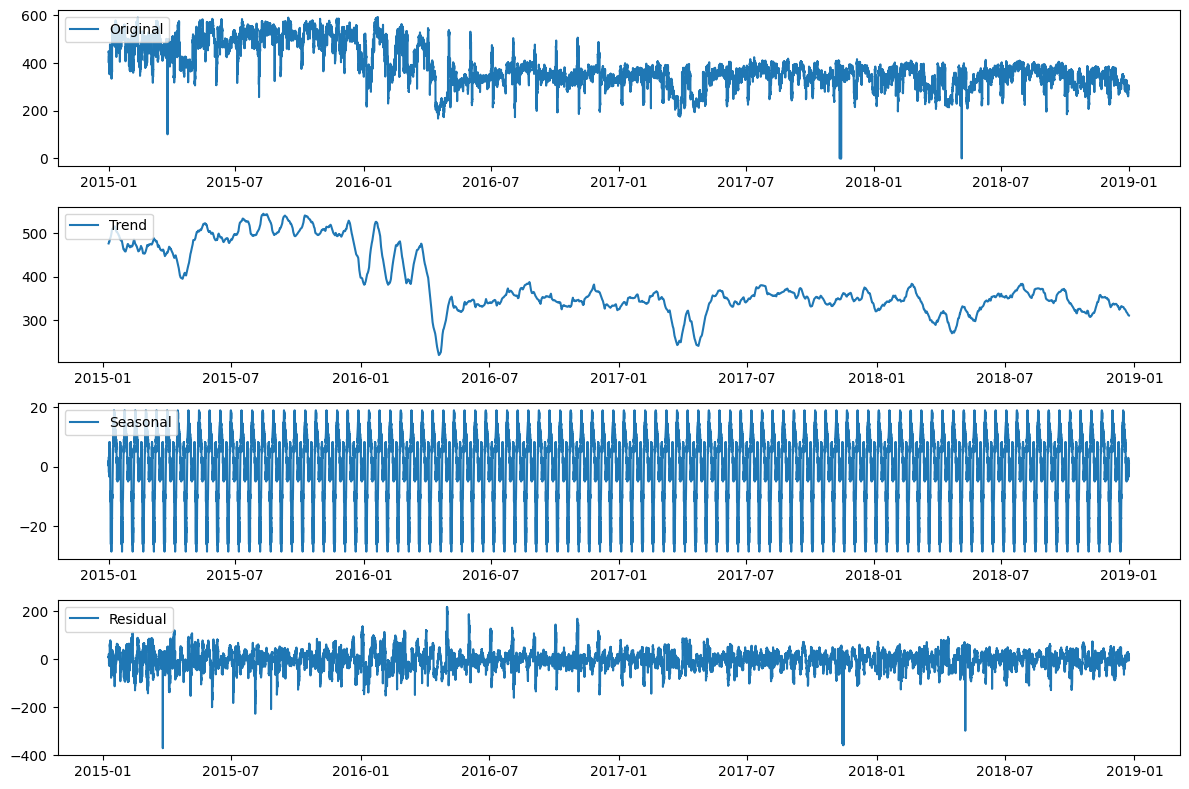

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Aplicar SCA a la serie de tiempo "generation biomass"
result = seasonal_decompose(df_biomass["generation biomass"], model="additive", period=365)  # Ajusta el período si es necesario

# Obtener los componentes de la descomposición
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Visualizar los componentes
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df_biomass["time"], df_biomass["generation biomass"], label="Original")
plt.legend(loc="upper left")
plt.subplot(412)
plt.plot(df_biomass["time"], trend, label="Trend")
plt.legend(loc="upper left")
plt.subplot(413)
plt.plot(df_biomass["time"], seasonal, label="Seasonal")
plt.legend(loc="upper left")
plt.subplot(414)
plt.plot(df_biomass["time"], residual, label="Residual")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

Error Cuadrático Medio (MSE): 0.3866
Error Absoluto Medio (MAE): 0.4540


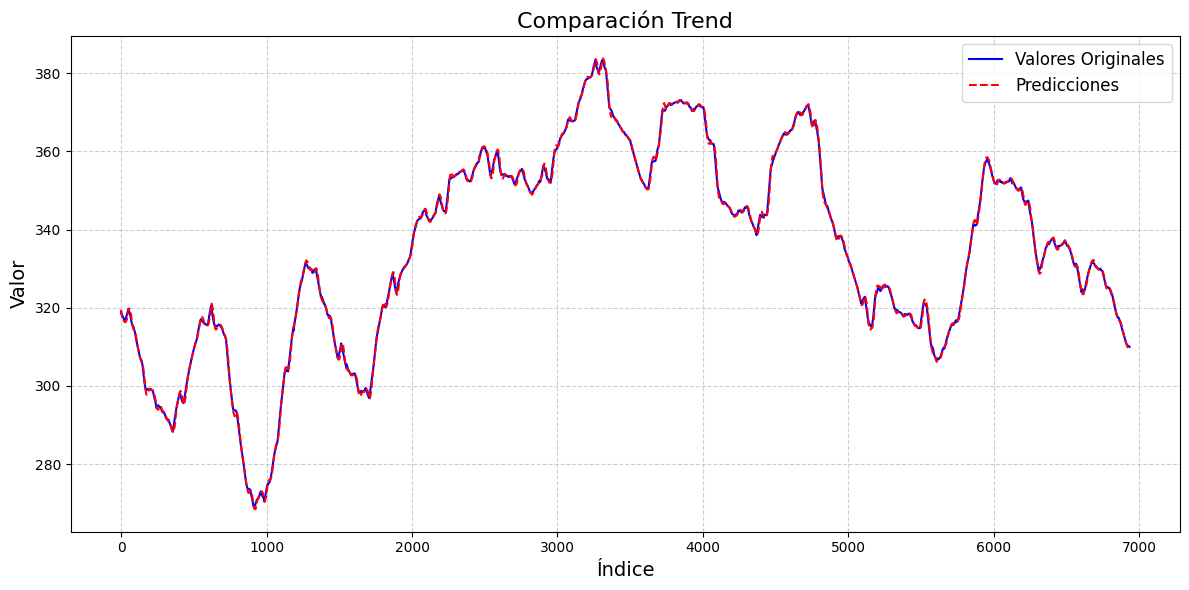

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose

# Cargar el archivo CSV
df = pd.read_csv("energy_dataset.csv")

# Convertir la columna 'time' a formato datetime
df['time'] = pd.to_datetime(df['time'], utc=True)

# Seleccionar la columna "generation biomass"
df_biomass = df[["time", "generation biomass"]]

# Rellenar valores faltantes usando interpolación lineal
df_biomass = df_biomass.copy()  # Crear una copia explícita
df_biomass.loc[:, "generation biomass"] = df_biomass["generation biomass"].interpolate(method="linear")

# Descomposición de la serie temporal
result = seasonal_decompose(df_biomass["generation biomass"], model="additive", period=365)
trend = result.trend.dropna()  # Eliminar NaNs

# Función para preparar datos con ventanas temporales
def prepare_data_with_windows(series, window_size=10):
    """
    Prepara los datos para entrenar un MLP usando ventanas temporales.
    Args:
        series: Serie temporal (pandas Series).
        window_size: Tamaño de la ventana temporal.
    Returns:
        X_train, X_test, y_train, y_test
    """
    if len(series) <= window_size:
        raise ValueError("La longitud de la serie debe ser mayor que el tamaño de la ventana.")

    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series.iloc[i:i + window_size].values)  # Ventana de tamaño `window_size`
        y.append(series.iloc[i + window_size])           # Valor siguiente como etiqueta
    X, y = np.array(X), np.array(y)
    return train_test_split(X, y, test_size=0.2, shuffle=False)

# Preparar datos para la componente "trend" con ventanas temporales
window_size = 30  # Usamos una ventana de 30 puntos
try:
    X_train_trend, X_test_trend, y_train_trend, y_test_trend = prepare_data_with_windows(trend, window_size)
except ValueError as e:
    print(f"Error al preparar los datos: {e}")
    exit()

# Crear y entrenar el MLP
mlp = MLPRegressor(
    hidden_layer_sizes=(100, 50),  # Dos capas ocultas: 100 y 50 neuronas
    activation='relu',             # Función de activación ReLU
    solver='adam',                 # Optimizador Adam
    max_iter=2000,                 # Incrementamos el número máximo de iteraciones
    random_state=42,               # Semilla para reproducibilidad
    early_stopping=True,           # Detener el entrenamiento si no mejora
    validation_fraction=0.2        # Fracción de datos para validación
)
mlp.fit(X_train_trend, y_train_trend)

# Realizar predicciones
y_pred_trend = mlp.predict(X_test_trend)

# Evaluar el modelo
mse = mean_squared_error(y_test_trend, y_pred_trend)
mae = mean_absolute_error(y_test_trend, y_pred_trend)
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Error Absoluto Medio (MAE): {mae:.4f}")

# Función para comparar predicciones con valores originales
def plot_predictions(y_test, y_pred, title):
    """
    Grafica las predicciones vs valores originales.
    Args:
        y_test: Valores reales.
        y_pred: Predicciones.
        title: Título del gráfico.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label="Valores Originales", color="blue")
    plt.plot(y_pred, label="Predicciones", color="red", linestyle="--")
    plt.title(title, fontsize=16)
    plt.xlabel("Índice", fontsize=14)
    plt.ylabel("Valor", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Comparar resultados para la componente "trend"
plot_predictions(y_test_trend, y_pred_trend, "Comparación Trend")

Error Cuadrático Medio (MSE): 0.0067
Error Absoluto Medio (MAE): 0.0521


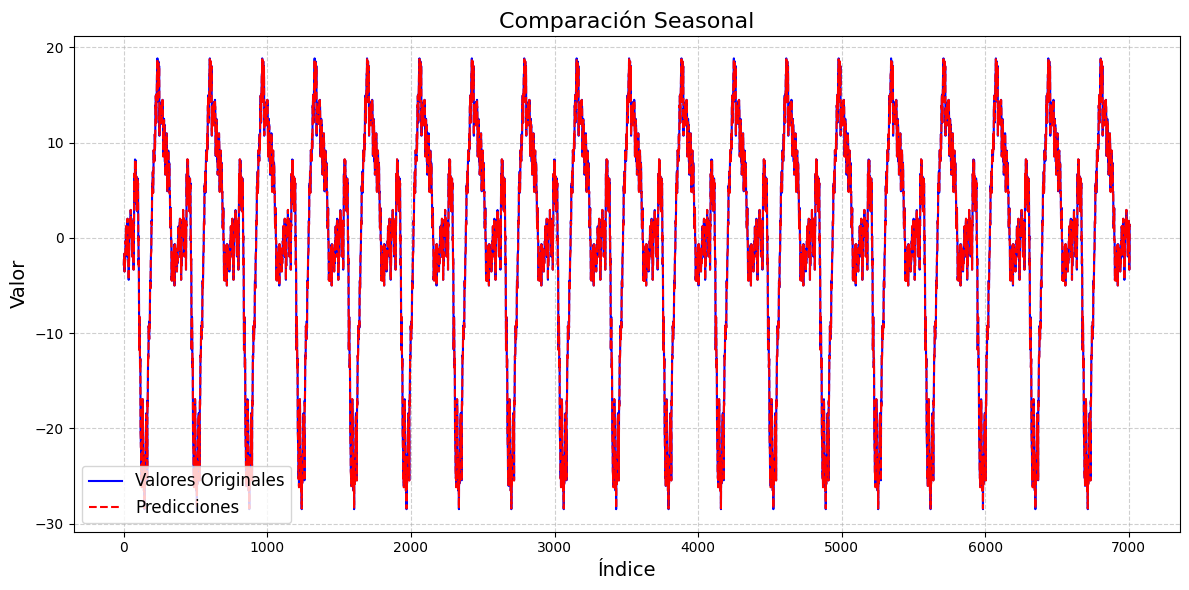

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose

# Cargar el archivo CSV
df = pd.read_csv("energy_dataset.csv")

# Convertir la columna 'time' a formato datetime
df['time'] = pd.to_datetime(df['time'], utc=True)

# Seleccionar la columna "generation biomass"
df_biomass = df[["time", "generation biomass"]]

# Rellenar valores faltantes usando interpolación lineal
df_biomass = df_biomass.copy()  # Crear una copia explícita
df_biomass.loc[:, "generation biomass"] = df_biomass["generation biomass"].interpolate(method="linear")

# Descomposición de la serie temporal
result = seasonal_decompose(df_biomass["generation biomass"], model="additive", period=365)
seasonal = result.seasonal.dropna()  # Eliminar NaNs

# Función para preparar datos con ventanas temporales
def prepare_data_with_windows(series, window_size=10):
    """
    Prepara los datos para entrenar un MLP usando ventanas temporales.
    Args:
        series: Serie temporal (pandas Series).
        window_size: Tamaño de la ventana temporal.
    Returns:
        X_train, X_test, y_train, y_test
    """
    if len(series) <= window_size:
        raise ValueError("La longitud de la serie debe ser mayor que el tamaño de la ventana.")

    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series.iloc[i:i + window_size].values)  # Ventana de tamaño `window_size`
        y.append(series.iloc[i + window_size])           # Valor siguiente como etiqueta
    X, y = np.array(X), np.array(y)
    return train_test_split(X, y, test_size=0.2, shuffle=False)

# Preparar datos para la componente "seasonal" con ventanas temporales
window_size = 30  # Usamos una ventana de 30 puntos
try:
    X_train_seasonal, X_test_seasonal, y_train_seasonal, y_test_seasonal = prepare_data_with_windows(seasonal, window_size)
except ValueError as e:
    print(f"Error al preparar los datos: {e}")
    exit()

# Crear y entrenar el MLP
mlp = MLPRegressor(
    hidden_layer_sizes=(100, 50),  # Dos capas ocultas: 100 y 50 neuronas
    activation='relu',             # Función de activación ReLU
    solver='adam',                 # Optimizador Adam
    max_iter=2000,                 # Incrementamos el número máximo de iteraciones
    random_state=42,               # Semilla para reproducibilidad
    early_stopping=True,           # Detener el entrenamiento si no mejora
    validation_fraction=0.2        # Fracción de datos para validación
)
mlp.fit(X_train_seasonal, y_train_seasonal)

# Realizar predicciones
y_pred_seasonal = mlp.predict(X_test_seasonal)

# Evaluar el modelo
mse = mean_squared_error(y_test_seasonal, y_pred_seasonal)
mae = mean_absolute_error(y_test_seasonal, y_pred_seasonal)
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Error Absoluto Medio (MAE): {mae:.4f}")

# Función para comparar predicciones con valores originales
def plot_predictions(y_test, y_pred, title):
    """
    Grafica las predicciones vs valores originales.
    Args:
        y_test: Valores reales.
        y_pred: Predicciones.
        title: Título del gráfico.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label="Valores Originales", color="blue")
    plt.plot(y_pred, label="Predicciones", color="red", linestyle="--")
    plt.title(title, fontsize=16)
    plt.xlabel("Índice", fontsize=14)
    plt.ylabel("Valor", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Comparar resultados para la componente "seasonal"
plot_predictions(y_test_seasonal, y_pred_seasonal, "Comparación Seasonal")

Error Cuadrático Medio (MSE): 138.4120
Error Absoluto Medio (MAE): 6.1165


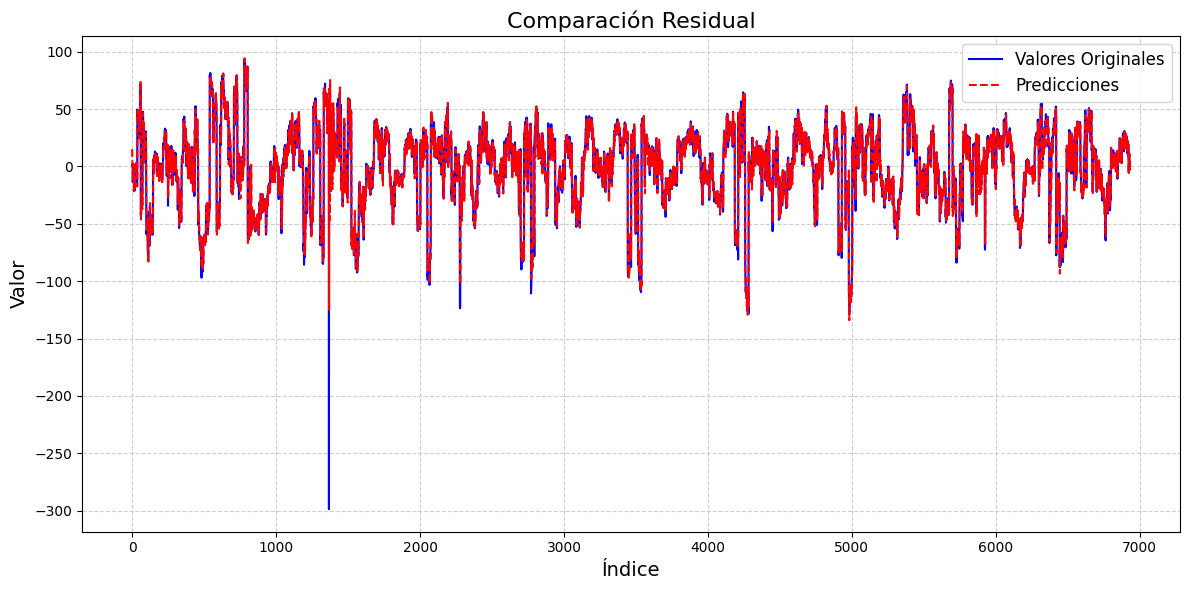

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose

# Cargar el archivo CSV
df = pd.read_csv("energy_dataset.csv")

# Convertir la columna 'time' a formato datetime
df['time'] = pd.to_datetime(df['time'], utc=True)

# Seleccionar la columna "generation biomass"
df_biomass = df[["time", "generation biomass"]]

# Rellenar valores faltantes usando interpolación lineal
df_biomass = df_biomass.copy()  # Crear una copia explícita
df_biomass.loc[:, "generation biomass"] = df_biomass["generation biomass"].interpolate(method="linear")

# Descomposición de la serie temporal
result = seasonal_decompose(df_biomass["generation biomass"], model="additive", period=365)
residual = result.resid.dropna()  # Eliminar NaNs

# Función para preparar datos con ventanas temporales
def prepare_data_with_windows(series, window_size=10):
    """
    Prepara los datos para entrenar un MLP usando ventanas temporales.
    Args:
        series: Serie temporal (pandas Series).
        window_size: Tamaño de la ventana temporal.
    Returns:
        X_train, X_test, y_train, y_test
    """
    if len(series) <= window_size:
        raise ValueError("La longitud de la serie debe ser mayor que el tamaño de la ventana.")

    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series.iloc[i:i + window_size].values)  # Ventana de tamaño `window_size`
        y.append(series.iloc[i + window_size])           # Valor siguiente como etiqueta
    X, y = np.array(X), np.array(y)
    return train_test_split(X, y, test_size=0.2, shuffle=False)

# Preparar datos para la componente "residual" con ventanas temporales
window_size = 30  # Usamos una ventana de 30 puntos
try:
    X_train_residual, X_test_residual, y_train_residual, y_test_residual = prepare_data_with_windows(residual, window_size)
except ValueError as e:
    print(f"Error al preparar los datos: {e}")
    exit()

# Crear y entrenar el MLP
mlp = MLPRegressor(
    hidden_layer_sizes=(100, 50),  # Dos capas ocultas: 100 y 50 neuronas
    activation='relu',             # Función de activación ReLU
    solver='adam',                 # Optimizador Adam
    max_iter=2000,                 # Incrementamos el número máximo de iteraciones
    random_state=42,               # Semilla para reproducibilidad
    early_stopping=True,           # Detener el entrenamiento si no mejora
    validation_fraction=0.2        # Fracción de datos para validación
)
mlp.fit(X_train_residual, y_train_residual)

# Realizar predicciones
y_pred_residual = mlp.predict(X_test_residual)

# Evaluar el modelo
mse = mean_squared_error(y_test_residual, y_pred_residual)
mae = mean_absolute_error(y_test_residual, y_pred_residual)
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Error Absoluto Medio (MAE): {mae:.4f}")

# Función para comparar predicciones con valores originales
def plot_predictions(y_test, y_pred, title):
    """
    Grafica las predicciones vs valores originales.
    Args:
        y_test: Valores reales.
        y_pred: Predicciones.
        title: Título del gráfico.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label="Valores Originales", color="blue")
    plt.plot(y_pred, label="Predicciones", color="red", linestyle="--")
    plt.title(title, fontsize=16)
    plt.xlabel("Índice", fontsize=14)
    plt.ylabel("Valor", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Comparar resultados para la componente "residual"
plot_predictions(y_test_residual, y_pred_residual, "Comparación Residual")

Error Cuadrático Medio (MSE) Reconstruido: 139.3018
Error Absoluto Medio (MAE) Reconstruido: 6.1380


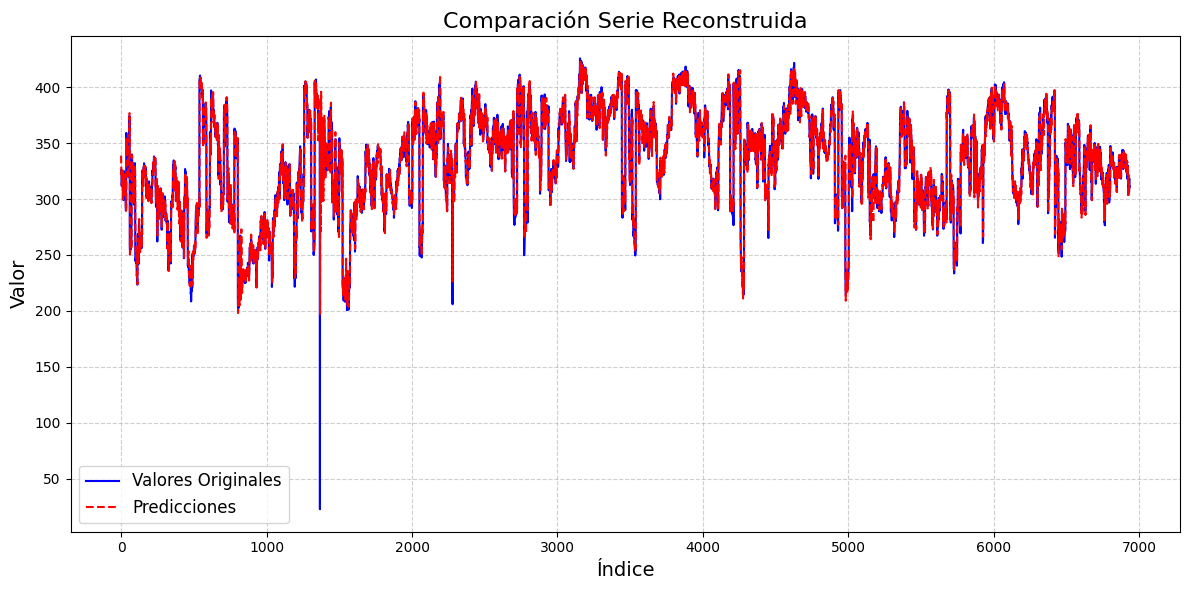

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose

# Cargar el archivo CSV
df = pd.read_csv("energy_dataset.csv")

# Convertir la columna 'time' a formato datetime
df['time'] = pd.to_datetime(df['time'], utc=True)

# Seleccionar la columna "generation biomass"
df_biomass = df[["time", "generation biomass"]]

# Rellenar valores faltantes usando interpolación lineal
df_biomass = df_biomass.copy()  # Crear una copia explícita
df_biomass.loc[:, "generation biomass"] = df_biomass["generation biomass"].interpolate(method="linear")

# Descomposición de la serie temporal
result = seasonal_decompose(df_biomass["generation biomass"], model="additive", period=365)
trend = result.trend.dropna()  # Eliminar NaNs
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()

# Función para preparar datos con ventanas temporales
def prepare_data_with_windows(series, window_size=10):
    """
    Prepara los datos para entrenar un MLP usando ventanas temporales.
    Args:
        series: Serie temporal (pandas Series).
        window_size: Tamaño de la ventana temporal.
    Returns:
        X_train, X_test, y_train, y_test
    """
    if len(series) <= window_size:
        raise ValueError("La longitud de la serie debe ser mayor que el tamaño de la ventana.")

    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series.iloc[i:i + window_size].values)  # Ventana de tamaño `window_size`
        y.append(series.iloc[i + window_size])           # Valor siguiente como etiqueta
    X, y = np.array(X), np.array(y)
    return train_test_split(X, y, test_size=0.2, shuffle=False)

# Configuración del MLP
def train_mlp(X_train, y_train):
    mlp = MLPRegressor(
        hidden_layer_sizes=(100, 50),  # Dos capas ocultas: 100 y 50 neuronas
        activation='relu',             # Función de activación ReLU
        solver='adam',                 # Optimizador Adam
        max_iter=2000,                 # Incrementamos el número máximo de iteraciones
        random_state=42,               # Semilla para reproducibilidad
        early_stopping=True,           # Detener el entrenamiento si no mejora
        validation_fraction=0.2        # Fracción de datos para validación
    )
    mlp.fit(X_train, y_train)
    return mlp

# Entrenar MLP para cada componente
window_size = 30

# Asegurar que todas las componentes tengan la misma longitud
min_length = min(len(trend), len(seasonal), len(residual))
trend = trend.iloc[:min_length]
seasonal = seasonal.iloc[:min_length]
residual = residual.iloc[:min_length]

X_train_trend, X_test_trend, y_train_trend, y_test_trend = prepare_data_with_windows(trend, window_size)
mlp_trend = train_mlp(X_train_trend, y_train_trend)
y_pred_trend = mlp_trend.predict(X_test_trend)

X_train_seasonal, X_test_seasonal, y_train_seasonal, y_test_seasonal = prepare_data_with_windows(seasonal, window_size)
mlp_seasonal = train_mlp(X_train_seasonal, y_train_seasonal)
y_pred_seasonal = mlp_seasonal.predict(X_test_seasonal)

X_train_residual, X_test_residual, y_train_residual, y_test_residual = prepare_data_with_windows(residual, window_size)
mlp_residual = train_mlp(X_train_residual, y_train_residual)
y_pred_residual = mlp_residual.predict(X_test_residual)

# Reconstruir la serie temporal completa
y_test_original = y_test_trend + y_test_seasonal + y_test_residual
y_pred_reconstructed = y_pred_trend + y_pred_seasonal + y_pred_residual

# Evaluar el modelo reconstruido
mse = mean_squared_error(y_test_original, y_pred_reconstructed)
mae = mean_absolute_error(y_test_original, y_pred_reconstructed)
print(f"Error Cuadrático Medio (MSE) Reconstruido: {mse:.4f}")
print(f"Error Absoluto Medio (MAE) Reconstruido: {mae:.4f}")

# Función para comparar predicciones con valores originales
def plot_predictions(y_test, y_pred, title):
    """
    Grafica las predicciones vs valores originales.
    Args:
        y_test: Valores reales.
        y_pred: Predicciones.
        title: Título del gráfico.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label="Valores Originales", color="blue")
    plt.plot(y_pred, label="Predicciones", color="red", linestyle="--")
    plt.title(title, fontsize=16)
    plt.xlabel("Índice", fontsize=14)
    plt.ylabel("Valor", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Comparar resultados para la serie reconstruida
plot_predictions(y_test_original, y_pred_reconstructed, "Comparación Serie Reconstruida")

Error Cuadrático Medio (MSE) Reconstruido: 139.3018
Error Absoluto Medio (MAE) Reconstruido: 6.1380


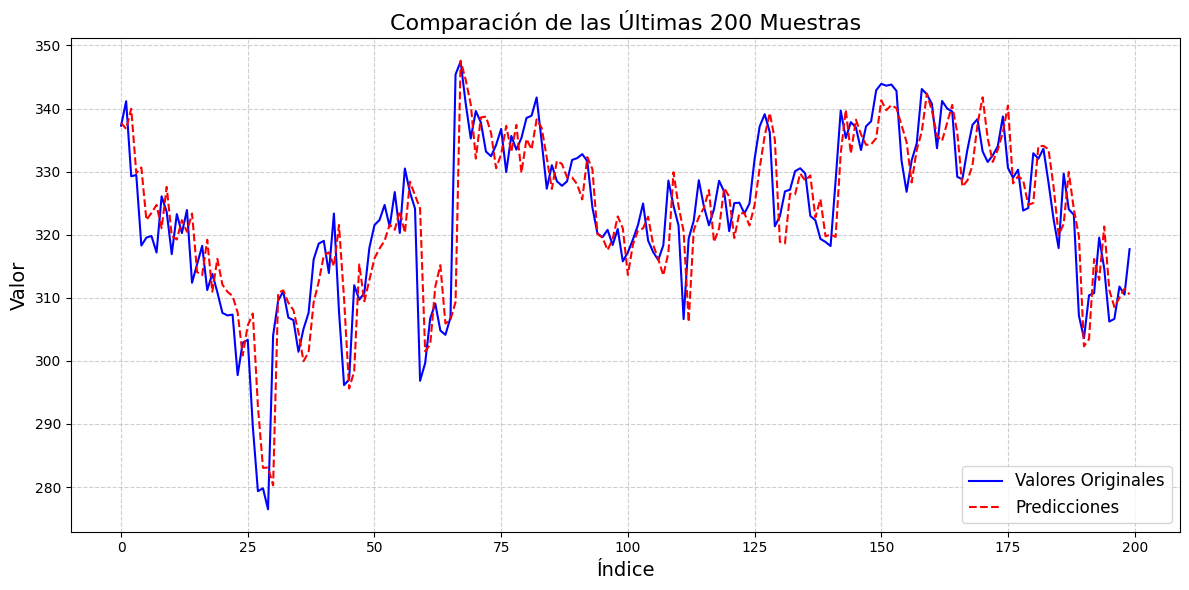

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose

# Cargar el archivo CSV
df = pd.read_csv("energy_dataset.csv")

# Convertir la columna 'time' a formato datetime
df['time'] = pd.to_datetime(df['time'], utc=True)

# Seleccionar la columna "generation biomass"
df_biomass = df[["time", "generation biomass"]]

# Rellenar valores faltantes usando interpolación lineal
df_biomass = df_biomass.copy()  # Crear una copia explícita
df_biomass.loc[:, "generation biomass"] = df_biomass["generation biomass"].interpolate(method="linear")

# Descomposición de la serie temporal
result = seasonal_decompose(df_biomass["generation biomass"], model="additive", period=365)
trend = result.trend.dropna()  # Eliminar NaNs
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()

# Función para preparar datos con ventanas temporales
def prepare_data_with_windows(series, window_size=10):
    """
    Prepara los datos para entrenar un MLP usando ventanas temporales.
    Args:
        series: Serie temporal (pandas Series).
        window_size: Tamaño de la ventana temporal.
    Returns:
        X_train, X_test, y_train, y_test
    """
    if len(series) <= window_size:
        raise ValueError("La longitud de la serie debe ser mayor que el tamaño de la ventana.")

    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series.iloc[i:i + window_size].values)  # Ventana de tamaño `window_size`
        y.append(series.iloc[i + window_size])           # Valor siguiente como etiqueta
    X, y = np.array(X), np.array(y)
    return train_test_split(X, y, test_size=0.2, shuffle=False)

# Configuración del MLP
def train_mlp(X_train, y_train):
    mlp = MLPRegressor(
        hidden_layer_sizes=(100, 50),  # Dos capas ocultas: 100 y 50 neuronas
        activation='relu',             # Función de activación ReLU
        solver='adam',                 # Optimizador Adam
        max_iter=2000,                 # Incrementamos el número máximo de iteraciones
        random_state=42,               # Semilla para reproducibilidad
        early_stopping=True,           # Detener el entrenamiento si no mejora
        validation_fraction=0.2        # Fracción de datos para validación
    )
    mlp.fit(X_train, y_train)
    return mlp

# Entrenar MLP para cada componente
window_size = 30

# Asegurar que todas las componentes tengan la misma longitud
min_length = min(len(trend), len(seasonal), len(residual))
trend = trend.iloc[:min_length]
seasonal = seasonal.iloc[:min_length]
residual = residual.iloc[:min_length]

X_train_trend, X_test_trend, y_train_trend, y_test_trend = prepare_data_with_windows(trend, window_size)
mlp_trend = train_mlp(X_train_trend, y_train_trend)
y_pred_trend = mlp_trend.predict(X_test_trend)

X_train_seasonal, X_test_seasonal, y_train_seasonal, y_test_seasonal = prepare_data_with_windows(seasonal, window_size)
mlp_seasonal = train_mlp(X_train_seasonal, y_train_seasonal)
y_pred_seasonal = mlp_seasonal.predict(X_test_seasonal)

X_train_residual, X_test_residual, y_train_residual, y_test_residual = prepare_data_with_windows(residual, window_size)
mlp_residual = train_mlp(X_train_residual, y_train_residual)
y_pred_residual = mlp_residual.predict(X_test_residual)

# Reconstruir la serie temporal completa
y_test_original = y_test_trend + y_test_seasonal + y_test_residual
y_pred_reconstructed = y_pred_trend + y_pred_seasonal + y_pred_residual

# Evaluar el modelo reconstruido
mse = mean_squared_error(y_test_original, y_pred_reconstructed)
mae = mean_absolute_error(y_test_original, y_pred_reconstructed)
print(f"Error Cuadrático Medio (MSE) Reconstruido: {mse:.4f}")
print(f"Error Absoluto Medio (MAE) Reconstruido: {mae:.4f}")

# Función para comparar predicciones con valores originales
def plot_predictions_last_samples(y_test, y_pred, title, num_samples=200):
    """
    Grafica las últimas `num_samples` muestras de las predicciones vs valores originales.
    Args:
        y_test: Valores reales.
        y_pred: Predicciones.
        title: Título del gráfico.
        num_samples: Número de muestras finales a graficar.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(y_test[-num_samples:], label="Valores Originales", color="blue")
    plt.plot(y_pred[-num_samples:], label="Predicciones", color="red", linestyle="--")
    plt.title(title, fontsize=16)
    plt.xlabel("Índice", fontsize=14)
    plt.ylabel("Valor", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Comparar resultados para las últimas 200 muestras
plot_predictions_last_samples(y_test_original, y_pred_reconstructed, "Comparación de las Últimas 200 Muestras")